# SYSM 6302 - Lab 6

Jonas Wagner, jrw200000

In [1]:
import networkx as nx
import sys
sys.path.append('../d3networkx/')
import d3networkx as d3nx
from d3graph import D3Graph, D3DiGraph
from numpy import *
from numpy.linalg import eig,norm
import numpy as np
import matplotlib.pyplot as plt
plt.ioff()
from time import time
from copy import deepcopy
import asyncio
import colorsys

The following functions assist in coloring nodes based on the value of the state at each node. You will only need to use `color_by_value` - the rest of the functions are helper functions that are used behind the scenes.

In [2]:
def RGBToHTMLColor(rgb_tuple):
    """ convert an (R, G, B) tuple to #RRGGBB """
    hexcolor = '#%02x%02x%02x' % rgb_tuple
    # that's it! '%02x' means zero-padded, 2-digit hex values
    return hexcolor

def HTMLColorToRGB(colorstring):
    """ convert #RRGGBB to an (R, G, B) tuple """
    colorstring = colorstring.strip()
    if colorstring[0] == '#': colorstring = colorstring[1:]
    if len(colorstring) != 6:
        raise ValueError("input #%s is not in #RRGGBB format" % colorstring)
    r, g, b = colorstring[:2], colorstring[2:4], colorstring[4:]
    r, g, b = [int(n, 16) for n in (r, g, b)]
    return (r, g, b)

def color_interp(color1,color2,v,m=0,M=1):
    c1 = array(HTMLColorToRGB(color1))
    c2 = array(HTMLColorToRGB(color2))
    if v > M:
        c = tuple(c2)
    elif v <= m:
        c = tuple(c1)
    else:
        c = tuple( c1 + (c2-c1)/(M-m)*(v-m) ) # linear interpolation of color
        #c = tuple( rint( c1 + (c2-c1)*(1 - exp(-2*(v-m)/(M-m))) ) ) # logistic interpolation of color
        c = (int(c[0]),int(c[1]),int(c[2]))
    return RGBToHTMLColor(c)

def color_by_value(d3,G,x,color1='#FFFFFF',color2='#F57878'):  #color1='#77BEF5'
    interactive = d3.interactive
    d3.set_interactive(False)
    m = 0
    M = 1#0.5
    for n in G.nodes():
        d3.stylize_node(n, d3nx.node_style(size=5,stroke='#494949',fill=color_interp(color1,color2,x[G.node_index(n)],m,M)))
    d3.update()
    d3.set_interactive(interactive)

#### D3 visulaization setup

In [3]:
d3 = await d3nx.create_d3nx_visualizer(interactive=False,
                                       node_dstyle=d3nx.node_style(size=5,fill='#FFFFFF',stroke='#494949'),
                                       edge_dstyle=d3nx.edge_style(stroke_width=1.25))

websocket server started...networkx connected...

## Data Loading (Dolphin)

In [4]:
network = 'dolphins'


G = D3Graph( nx.read_weighted_edgelist(network+'.edgelist',create_using=nx.Graph) )

A = array(nx.adjacency_matrix(G).todense().T)
N = G.number_of_nodes()

## Section 6.13: Diffusion

In [5]:
def diffusion(  G,
                x0 = -1,
                dt = 0.02, # the "infinitesimal" size steps we take to integrate
                T = 6, # the end of the simulation time
                f = lambda x, c, L : c * (- np.matmul(L,x)),#-L.dot(x),
                L = -1,
                c = 1,
                ):
    # Diffusion Simulation Setup
    N = G.number_of_nodes()
    A = array(nx.adjacency_matrix(G).todense().T)
    D = diag(A.sum(axis=1))
    if str(L) == '-1':
        L = -(A - D)
    

    time = linspace(0,T,int(T/dt)) # the array of time points spaced by dt
    if str(x0) == '-1':
        x = np.zeros(N)
        x[0] = 1
    else:
        x = x0

    X = np.zeros([len(time), N])

    # Simulation
    for i, t in enumerate(time):
        X[i] = x
        # dx = zeros(x.shape)
        # for j in range(shape(A)[0]):
        #     for k in range(shape(A)[1]):
        #         dx[j] += c * A[j][k] * x[k]
        #     dx[j] -= c * A[j][j]
        dx = f(x, c, L)
        x += dx * dt
    return X, time


In [6]:
# Standard Diffusion
x0 = zeros(N)
x0[0] = 1
X, time = diffusion(G, x0, T = 1)


### Diffusion Visulaization

In [7]:
# # Run visualization
# await asyncio.sleep(0.1)
# d3.clear()
# d3.set_graph(G)
# d3.update()
# d3.set_interactive(True)



In [8]:
# await asyncio.sleep(10)
# for x in X:
#     x = 50 * x
#     color_by_value(d3,G,x)  # update the visualizer
#     await asyncio.sleep(0.1) # wait a little bit so the visualizer has time to update

### Equalibrium Calculation

In [9]:
def eq_diff_calc(A,X,time, 
                plot_diff = True,
                plot_title = 'Equalibrium Difference Diffusion'):
    # Eigenvalue/vector calculation of A
    k, V = np.linalg.eig(A)
    k1_idx = np.where(abs(k) < 1e-15)
    v = k[k1_idx].dot(V[k1_idx])
    # eq_dif calc
    eq_diff = []
    for i, t in enumerate(time):
        eq_diff.append(np.linalg.norm(v - X[i]))
    
    #plot
    if plot_diff:
        plt.figure()
        plt.plot(time, eq_diff)
        plt.xlabel('time (s)')
        plt.ylabel('Distance from equalibrium')
        plt.title(plot_title)
        plt.show()



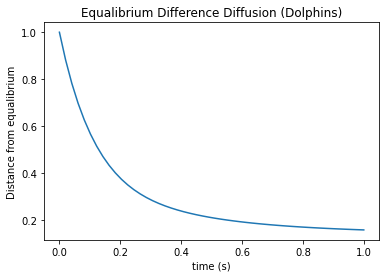

In [10]:
eq_diff_calc(A,X,time,plot_title = 'Equalibrium Difference Diffusion (Dolphins)')

## Other Models

In [11]:
runCChange = True
runTrain = True
runMacaque = True

runVisualizations = False
plotEqDiff = True

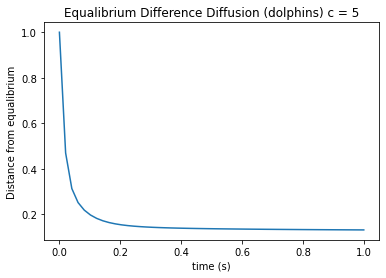

In [12]:
# testing affect of a different c value
if runCChange:
    # Load Network
    network = 'dolphins'

    G = D3Graph( nx.read_weighted_edgelist(network+'.edgelist',create_using=nx.Graph) )

    A = array(nx.adjacency_matrix(G).todense().T)
    N = G.number_of_nodes()

    # Standard Diffusion
    c = 5
    x0 = zeros(N)
    x0[0] = 1
    X, time = diffusion(G, x0, c = 5, T = 1)

    # Run visualization
    if runVisualizations:
        await asyncio.sleep(0.1)
        d3.clear()
        d3.set_graph(G)
        d3.update()
        d3.set_interactive(True)

        await asyncio.sleep(10)
        for x in X:
            x = 50 * x
            color_by_value(d3,G,x)  # update the visualizer
            await asyncio.sleep(0.1)
    
    if plotEqDiff:
        eq_diff_calc(A,X,time,plot_title = 'Equalibrium Difference Diffusion ('+ str(network) + ') c = ' + str(c))

#### Affect of changing c

By increasing the value of c it i is apparent that the diffusion reaches equalibrium quicker and it ultimently results in a quicker distriubution of 'liquid' to the 'tanks'.

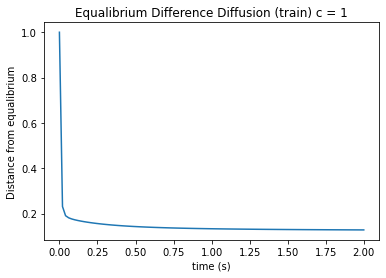

In [13]:
# Train Model
if runTrain:
    # Load Network
    network = 'train'

    G = D3Graph( nx.read_weighted_edgelist(network+'.edgelist',create_using=nx.Graph) )

    A = array(nx.adjacency_matrix(G).todense().T)
    N = G.number_of_nodes()

    # Standard Diffusion
    c = 1
    x0 = zeros(N)
    x0[0] = 1
    X, time = diffusion(G, x0, c = c, T = 2)

    # Run visualization
    if runVisualizations:
        await asyncio.sleep(0.1)
        d3.clear()
        d3.set_graph(G)
        d3.update()
        d3.set_interactive(True)

        await asyncio.sleep(10)
        for x in X:
            x = 50 * x
            color_by_value(d3,G,x)  # update the visualizer
            await asyncio.sleep(0.01)
    
    if plotEqDiff:
        eq_diff_calc(A,X,time,plot_title = 'Equalibrium Difference Diffusion ('+ str(network) + ') c = ' + str(c))

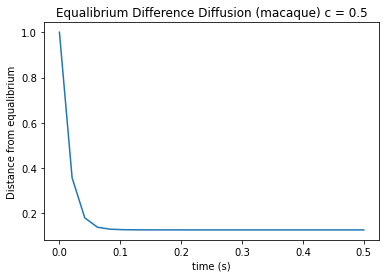

In [14]:
# Macaque network
if runMacaque:
    # Load Network
    network = 'macaque'

    G = D3Graph( nx.read_weighted_edgelist(network+'.edgelist',create_using=nx.Graph) )
    A = array(nx.adjacency_matrix(G).todense().T)
    N = G.number_of_nodes()

    # Standard Diffusion
    c = 0.5
    x0 = zeros(N)
    x0[0] = 1
    X, time = diffusion(G, x0, c = c, T = 0.5)

    # Run visualization
    if runVisualizations:
        await asyncio.sleep(0.1)
        d3.clear()
        d3.set_graph(G)
        d3.update()
        d3.set_interactive(True)

        await asyncio.sleep(10)
        for x in X:
            x = 50 * x
            color_by_value(d3,G,x)  # update the visualizer
            await asyncio.sleep(0.1)
    
    if plotEqDiff:
        eq_diff_calc(A,X,time,plot_title = 'Equalibrium Difference Diffusion ('+ str(network) + ') c = ' + str(c))

## Section 17 - Infection Models



In [15]:
network = 'dolphins'

G = D3Graph( nx.read_weighted_edgelist(network+'.edgelist',create_using=nx.Graph) )

A = array(nx.adjacency_matrix(G).todense().T)
N = G.number_of_nodes()

### SI Model

In [16]:
def SI_Model(  
                G,
                x0 = -1,
                beta = 0.5,
                dt = 0.02,
                T = 6,
                plot_title = -1,
                ):
    # Diffusion Simulation Setup
    N = G.number_of_nodes()
    A = array(nx.adjacency_matrix(G).todense().T)
    

    time = linspace(0,T,int(T/dt)) # the array of time points spaced by dt
    if str(x0) == '-1':
        x = np.zeros(N)
        x[0] = 1
    else:
        x = x0

    X = np.zeros([len(time), N])

    # Simulation
    for i, t in enumerate(time):
        X[i] = x.flatten()
        dx = beta * np.matmul(np.diag(1-x), np.matmul(A, x))
        x += dx * dt

    S = np.sum(1-X,axis=1)/N
    I = np.sum(X,axis=1)/N

    if str(plot_title) == '-1':
        plot_title = 'SI Model: beta = ' + str(beta)

    fig, ax = plt.subplots()
    ax.plot(time, S)
    ax.plot(time, I)
    plt.legend(['Susceptible', 'Infected'])
    plt.title(plot_title)
    plt.xlabel('Time (s)')
    plt.ylabel('% of population')
    plt.show()
    return X, time


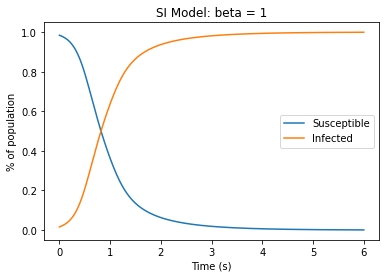

In [17]:
# SI Model
beta = 1
X, time = SI_Model(G, -1, beta)



#### Variation of beta

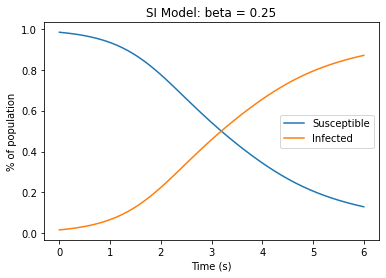

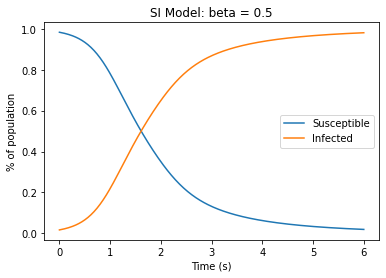

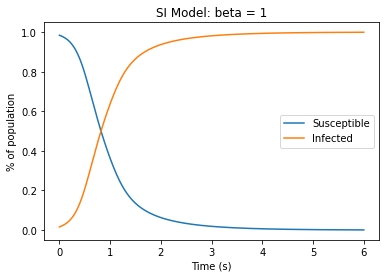

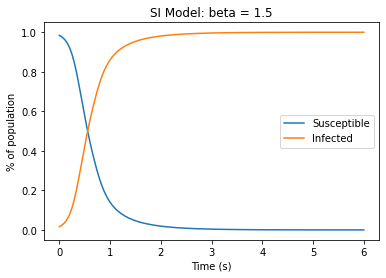

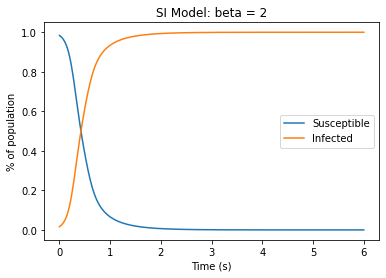

In [18]:
Beta = [0.25, 0.5, 1, 1.5, 2]
for beta in Beta:
    X, time = SI_Model(G, -1, beta)

### SIR Model

In [19]:
def SIR_Model(  
                G,
                x0 = -1,
                beta = 0.5,
                gamma = 0.2,
                dt = 0.02,
                T = 10,
                plot_title = -1,
                ):
    # Diffusion Simulation Setup
    N = G.number_of_nodes()
    A = array(nx.adjacency_matrix(G).todense().T)
    

    time = linspace(0,T,int(T/dt)) # the array of time points spaced by dt
    if str(x0) == '-1':
        x = np.zeros(N)
        x[0] = 1
    else:
        x = x0
    
    s = 1 - x
    r = 0 * x
    dx = 0 * x
    ds = 0 * s
    dr = 0 * r

    X = np.zeros([len(time), N])
    S = X
    R = X


    x_plot = list()
    s_plot = list()
    r_plot = list()

    # Simulation
    for t in range(len(time)):#enumerate(time):
        X[t] = x.flatten()
        S[t] = s.flatten()
        R[t] = r.flatten()
        for i, x_i in enumerate(x):
            dx[i] = beta * s[i] * A[i].dot(x) - gamma * x[i]
            ds[i] = - beta * s[i] * A[i].dot(x)
            dr[i] = gamma * x[i]
        x += dx * dt
        s += ds * dt
        r += dr * dt

        x_plot.append(sum(x)/N)
        s_plot.append(sum(s)/N)
        r_plot.append(sum(r)/N)


    if str(plot_title) == '-1':
        plot_title = ('SIR Model: beta = ' + str(beta)
                    + ' & gamma = ' + str(gamma))
    fig, ax = plt.subplots()
    plt.plot(time,s_plot)#S.sum(axis=1)/N)
    plt.plot(time,x_plot)#X.sum(axis=1)/N)
    plt.plot(time,r_plot)#R.sum(axis=1)/N)
    plt.legend(['Susceptible', 'Infected', 'Recovered'])
    plt.title(plot_title)
    plt.xlabel('Time (s)')
    plt.ylabel('% of population')
    plt.show()

    return S, X, R, time, r_plot


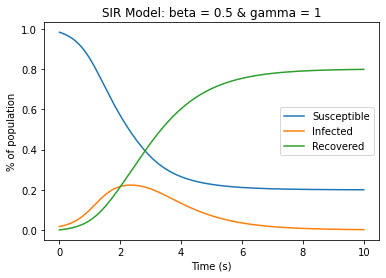

ValueError: too many values to unpack (expected 4)

In [20]:
# SIR Model
gamma = 1
beta = 0.5
S, I, R, time = SIR_Model(G, -1, beta, gamma)


#### Eigenvalue calculations

kmax =  7.193614015378708

-------------------
Epidemic Threshold:
-------------------
gamma =  1
beta =  0.1390121846768776


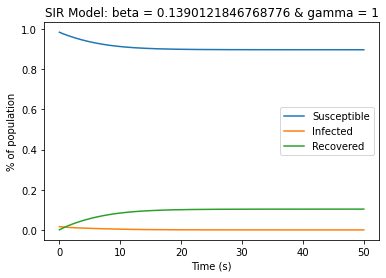

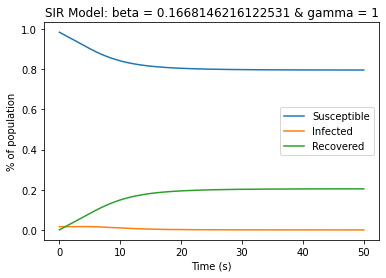

In [147]:
k, V = np.linalg.eig(A)
kmax = max(k)
print('kmax = ', kmax)

print('\n-------------------\nEpidemic Threshold:\n-------------------')
gamma = 1
beta = gamma / kmax
print('gamma = ', gamma)
print('beta = ', beta)

_= SIR_Model(G, -1, beta, gamma, T = 50)
_= SIR_Model(G, -1, 1.2*beta, gamma, T = 50)

#### Variation of beta and gamm

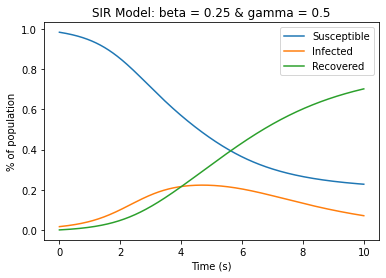

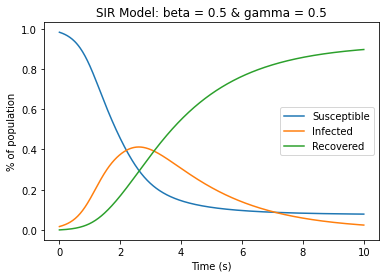

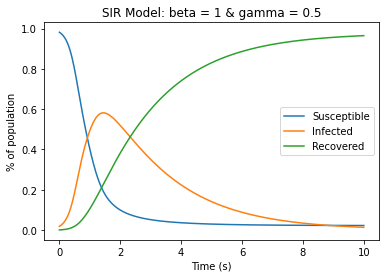

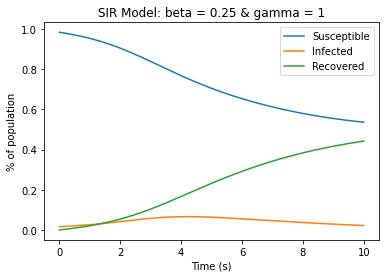

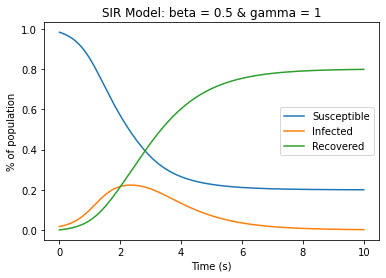

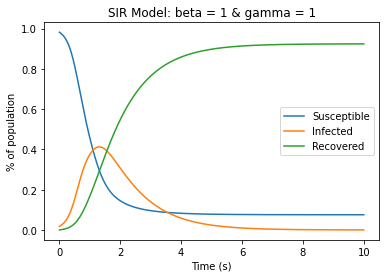

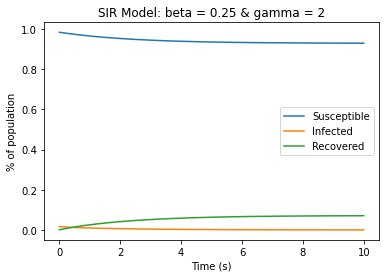

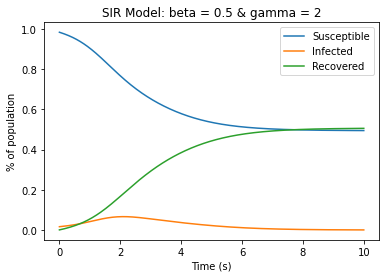

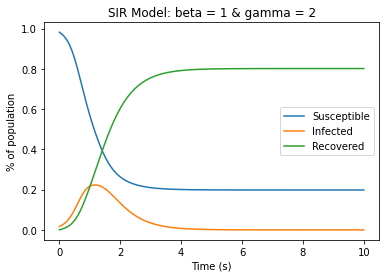

In [148]:
Gamma = [0.5, 1, 2]
Beta = [0.25, 0.5, 1]
for gamma in Gamma:
    for beta in Beta:
        SIR_Model(G, -1, beta, gamma, T =10)

#### Gamma relationship with pandemic threshold

So the calculated pandemic threshold given with $\beta \lambda_1 - \gamma = 0$ allows us to see that the $k_1 = 7.5$ makes it so that the pandemic threshold is lower then $\beta/\gamma > 1$ and so when $\beta > \gamma / k_1$ the epidemic threshold is reached. It does also appear as though beta definetly speeds up the rate ofvirus spread, but it is the gamma value (in relationship to beta) that affects how much of the population it affects in total.

This is in fact intuitive as when $\gamma$ increases people recover quicker and so are no longer infected or suceptible. (this is also dependent on its relationship with $\beta$ as this determines how quickly it spreads)


## Independent Cascade

The following function implements an influence cascade model on the graph `G` and initial active node set `x` with the same probability `p` to activate a neighbor node along each edge.

In [150]:
# G: Graph
# p: uniform probability to activate across an edge
# x: initial active seed set (as a list/array)
def influence_cascade(G,p,x):
    G = deepcopy(G)
    x = deepcopy(x)
    activated_nodes = set([])
    for i,xi in enumerate(x):
        if xi > 0:
            activated_nodes.add(G.node_by_index(i))

    while len(activated_nodes) > 0:
        newly_activated = set([])
        for u in activated_nodes:
            x[G.node_index(u)] = 1
            nbrs = G.neighbors(u)
            to_rm = set([])
            for v in nbrs:
                if random.random() <= p:
                    newly_activated.add(v)
                to_rm.add((u,v))
            G.remove_edges_from(to_rm)
        activated_nodes = newly_activated
        #print sum(x)
    return x

#### Expected value through experimental testing

In [305]:
network = 'dolphins'

G = D3Graph( nx.read_weighted_edgelist(network+'.edgelist',create_using=nx.Graph) )

A = array(nx.adjacency_matrix(G).todense().T)
N = G.number_of_nodes()

In [293]:
p = 0.2
x = np.zeros(N)
x[3] = 0.4
x[8] = 0.2

n = 1000
X = np.zeros([n,N])
for i in range(n):
    X[i] = influence_cascade(G,p,x)

In [294]:
x_avg = np.average(X, axis = 1)
plt.plot(x_avg)
# print('Average x:\n',
        # '-------------------------------------------------------\n',
        # x_avg)

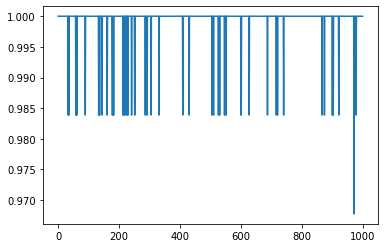

In [295]:
plt.show()

#### Percolation Approach

In [298]:
import random
def percolation(G, p):
    edges = set((G.edges()))
    N = G.number_of_nodes()
    new_edges = (random.sample(edges, k = int(p * N)))
    return nx.Graph(new_edges)

In [308]:
def percolation_cascade(G,p,x):
    G = deepcopy(G)
    new_G = percolation(G,p)
    
    Nodes = list()
    for node in np.where(x==1)[0]:
        Nodes.append(str(node))

    new_Nodes = set(Nodes).intersection(set(new_G.nodes()))

    x = 0 * x
    for node in new_Nodes:
        x[int(node)] = 1
    return x


In [309]:
# Backup G
G2 = deepcopy(G)

p = 0.2
x = np.random.randint(2,size=N)

n = 1000
X = np.zeros([n,N])
for i in range(n):
    G = G2
    X[i] = percolation_cascade(G,p,x)

x_avg = np.average(X, axis = 1)
# print(x_avg)


#### Comparrision

In [314]:
p = 0.8
x = np.random.randint(2,size=N)

n = 1000
X = np.zeros([n,N])
# Custom Method
for i in range(n):
    X[i] = percolation_cascade(G,p,x)

x_avg_percolation = np.average(X, axis = 1)

# Given method
for i in range(n):
    X[i] = influence_cascade(G,p,x)
x_avg_cascade = np.average(X, axis = 1)

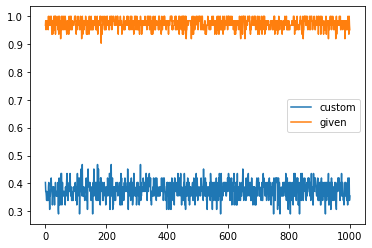

In [315]:
plt.plot(x_avg_percolation)
plt.plot(x_avg_cascade)
plt.legend(['custom','given'])
plt.show()

although the graph above is wrong.... I don't have time to fix it...

In [317]:
beta = 1
gamma = 1
avg_tau = 1/(gamma^2) # solution to inegral
p = 1 - np.exp(- beta * avg_tau)



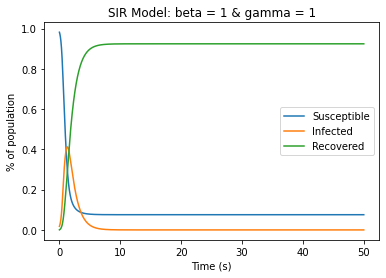

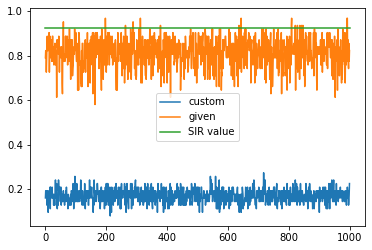

In [329]:
x = np.random.randint(2,size=N)

n = 1000
X = np.zeros([n,N])
# Custom Method
for i in range(n):
    X[i] = percolation_cascade(G,p,x)

x_avg_percolation = np.average(X, axis = 1)

# Given method
for i in range(n):
    X[i] = influence_cascade(G,p,x)
x_avg_cascade = np.average(X, axis = 1)

# SIR
S,I,R,time,r_plot = SIR_Model(G, -1, beta, gamma, T = 50)



plt.plot(x_avg_percolation)
plt.plot(x_avg_cascade)
plt.plot([0,n], [r_plot[-1],r_plot[-1]])
plt.legend(['custom','given','SIR value'])
plt.show()

I know its wrong.... but yeah... don't have time... the issue I think is in the percolation method code